In [1]:
import pandas as pd
import numpy as np
from sklearn.neural_network import MLPRegressor
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split

In [2]:
df = pd.read_csv("WTI.csv")
df['交易量'] = df['交易量'].apply(lambda x: x  if pd.isnull(x) else (float(x[:-1])*1000 if x.find("M")!= -1 else float(x[:-1])))
df['交易量'].fillna(np.mean(df['交易量']),inplace=True)
df

,日期,收盘,开盘,高,低,交易量,涨跌幅
0,2023/12/29,71.65,71.99,72.62,71.25,214.490000,-0.17%
1,2023/12/28,71.77,73.80,74.40,71.72,262.750000,-3.16%
2,2023/12/27,74.11,75.32,75.66,73.77,253.320000,-1.93%
3,2023/12/26,75.57,73.56,76.18,73.13,208.720000,2.41%
4,2023/12/25,73.79,73.49,73.94,73.48,437.315665,0.31%
...,...,...,...,...,...,...,...
1581,2018/1/5,61.44,61.90,62.04,61.09,563.040000,-0.92%
1582,2018/1/4,62.01,61.96,62.21,61.59,654.360000,0.62%
1583,2018/1/3,61.63,60.39,61.97,60.28,673.860000,2.09%
1584,2018/1/2,60.37,60.20,60.74,60.10,510.310000,0.22%


In [3]:
df.rename(columns={"日期":"Date","开盘":"Open_Price","收盘":"Close_Price","高":"Day_Max","低":"Day_Low","涨跌幅":"Percentage","交易量":"Volume"},inplace=True)

In [4]:
df = df.reindex(index=df.index[::-1])
df.reset_index(inplace=True, drop=True)
df

,Date,Close_Price,Open_Price,Day_Max,Day_Low,Volume,Percentage
0,2018/1/1,60.24,60.26,60.28,60.15,437.315665,-0.30%
1,2018/1/2,60.37,60.20,60.74,60.10,510.310000,0.22%
2,2018/1/3,61.63,60.39,61.97,60.28,673.860000,2.09%
3,2018/1/4,62.01,61.96,62.21,61.59,654.360000,0.62%
4,2018/1/5,61.44,61.90,62.04,61.09,563.040000,-0.92%
...,...,...,...,...,...,...,...
1581,2023/12/25,73.79,73.49,73.94,73.48,437.315665,0.31%
1582,2023/12/26,75.57,73.56,76.18,73.13,208.720000,2.41%
1583,2023/12/27,74.11,75.32,75.66,73.77,253.320000,-1.93%
1584,2023/12/28,71.77,73.80,74.40,71.72,262.750000,-3.16%


In [5]:
df["7_Days_MA"]=df["Close_Price"].rolling(window=7).mean().shift(1).fillna(0)
df["14_Days_MA"]=df["Close_Price"].rolling(window=14).mean().shift(1).fillna(0)
df["21_Days_MA"]=df["Close_Price"].rolling(window=21).mean().shift(1).fillna(0)
df["7_Days_SD"]=df["Close_Price"].rolling(window=7).std().shift(1).fillna(0)
df["O-C"] = df["Open_Price"] - df["Close_Price"]
df["H-L"] = df["Day_Max"] - df["Day_Low"]

In [6]:
def weighted_mean(var, wts):
    """Calculates the weighted mean"""
    return np.average(var, weights=wts)

def weighted_variance(var, wts):
    """Calculates the weighted variance"""
    return np.average((var - weighted_mean(var, wts))**2, weights=wts)

def weighted_skew(var, wts):
    """Calculates the weighted skewness"""
    return (np.average((var - weighted_mean(var, wts))**3, weights=wts) /
            weighted_variance(var, wts)**(1.5))

def weighted_kurtosis(var, wts):
    """Calculates the weighted skewness"""
    return (np.average((var - weighted_mean(var, wts))**4, weights=wts) /
            weighted_variance(var, wts)**(2))

In [7]:
comment_df = pd.read_csv("Reddit_Crude_Oil.csv")
comment_df["Date"] = pd.to_datetime(comment_df['date']).dt.date
comment_df["Scale_Sentiment"] = comment_df["Sentiment score"] * comment_df["Relatedness"]/100
comment_df["score"] = pd.to_numeric(comment_df["score"],errors='coerce').fillna(1)
#remove 0 weight
comment_df["score"].replace(0,1,inplace = True)

weight_avg = comment_df.groupby("Date").apply(lambda x: weighted_mean(x["Scale_Sentiment"],wts = x["score"])).to_frame("US_C_Avg")
count = comment_df.groupby("Date")["Sentiment score"].count().to_frame("US_C_Volume")
#weight_var = comment_df.groupby("date").apply(lambda x: weighted_variance(x["Scale_Sentiment"],wts = x["score"])).to_frame("Var")
#weight_skew = comment_df.groupby("date").apply(lambda x: weighted_skew(x["Scale_Sentiment"],wts = x["score"])).to_frame("Skew")
#weight_kurtosis = comment_df.groupby("date").apply(lambda x: weighted_kurtosis(x["Scale_Sentiment"],wts = x["score"])).to_frame("Kurtosis")

#features = [weight_avg,weight_var,weight_skew,weight_kurtosis]
features =[weight_avg,count]

comment_by_date = pd.DataFrame(index = comment_df["Date"].unique())
for item in features:
    comment_by_date = pd.merge(comment_by_date,item,left_index=True, right_index=True)
comment_by_date["Date"] = comment_by_date.index
comment_by_date

,US_C_Avg,US_C_Volume,Date
2020-03-08,-31.079340,39,2020-03-08
2020-03-09,4.548507,65,2020-03-09
2020-03-30,14.863480,405,2020-03-30
2020-03-31,-36.821642,49,2020-03-31
2020-04-01,-1.532652,179,2020-04-01
...,...,...,...
2024-01-28,-60.750000,2,2024-01-28
2024-03-11,-9.500000,7,2024-03-11
2024-03-12,17.250000,6,2024-03-12
2024-03-19,-12.031250,7,2024-03-19


In [8]:
unprocess_data = ["UK_C.csv","CN_C.csv"] 

for item in unprocess_data:
    comment_df = pd.read_csv(item)
    comment_df['Date'] = pd.to_datetime(comment_df['date']).dt.date
    comment_df.sort_values(by=["date"], ignore_index=True, inplace=True)
    comment_df["Sentiment Score"] = comment_df["Response"].apply(lambda x:0 if (not x.split("\n")[0].strip()[-2:].isdigit()) else (int(x.split("\n")[0].strip()[-3:]) if x.split("\n")[0][-3]!=":" else 0))
    comment_df["Relatedness"] = comment_df["Response"].apply(lambda x: 0 if (not x.split("\n")[1].strip()[-2:].isdigit()) else (int(x.split("\n")[1].strip()[-3:]) if x.split("\n")[1][-3]!=":" else 0))
    comment_df["Scale_Sentiment"] = comment_df["Sentiment Score"] * comment_df["Relatedness"]/100
    
    weight_avg = comment_df.groupby("Date").apply(lambda x: np.average(x["Scale_Sentiment"])).to_frame(item[:4]+"_Avg")
    count = comment_df.groupby("Date")["Sentiment Score"].count().to_frame(item[:4]+"_Volume")
    features =[weight_avg,count]
    for feature in features:
        comment_by_date =comment_by_date.merge(feature,on="Date",how="outer")
comment_by_date

,US_C_Avg,US_C_Volume,Date,UK_C_Avg,UK_C_Volume,CN_C_Avg,CN_C_Volume
0,-31.079340,39.0,2020-03-08,NaN,NaN,-3.692308,13.0
1,4.548507,65.0,2020-03-09,NaN,NaN,-1.627778,90.0
2,14.863480,405.0,2020-03-30,NaN,NaN,-6.939331,239.0
3,-36.821642,49.0,2020-03-31,36.875,4.0,-2.382252,262.0
4,-1.532652,179.0,2020-04-01,-2.850,5.0,-3.500000,62.0
...,...,...,...,...,...,...,...
1027,NaN,NaN,2023-12-06,NaN,NaN,-12.000000,1.0
1028,NaN,NaN,2023-12-07,NaN,NaN,-24.000000,1.0
1029,NaN,NaN,2023-12-11,NaN,NaN,0.000000,1.0
1030,NaN,NaN,2023-12-12,NaN,NaN,0.000000,1.0


In [9]:
comment_by_date.fillna(0)

,US_C_Avg,US_C_Volume,Date,UK_C_Avg,UK_C_Volume,CN_C_Avg,CN_C_Volume
0,-31.079340,39.0,2020-03-08,0.000,0.0,-3.692308,13.0
1,4.548507,65.0,2020-03-09,0.000,0.0,-1.627778,90.0
2,14.863480,405.0,2020-03-30,0.000,0.0,-6.939331,239.0
3,-36.821642,49.0,2020-03-31,36.875,4.0,-2.382252,262.0
4,-1.532652,179.0,2020-04-01,-2.850,5.0,-3.500000,62.0
...,...,...,...,...,...,...,...
1027,0.000000,0.0,2023-12-06,0.000,0.0,-12.000000,1.0
1028,0.000000,0.0,2023-12-07,0.000,0.0,-24.000000,1.0
1029,0.000000,0.0,2023-12-11,0.000,0.0,0.000000,1.0
1030,0.000000,0.0,2023-12-12,0.000,0.0,0.000000,1.0


In [10]:
X = df.drop(["Percentage","Open_Price","Close_Price","Day_Max","Day_Low"], axis=1)
X["Date"] =pd.to_datetime(X['Date']).dt.date
y = df["Close_Price"]
X = X.drop(df.loc[0:21].index)
y = y.drop(df.loc[0:22].index)
X = X.reset_index(drop=True)
y = y.reset_index(drop=True)
X = X.merge(comment_by_date,on="Date",how ="left").fillna(0)
X = X.drop(["Date"],axis=1)

In [11]:
y_pred = []
for i in range(1200,X.shape[0]):
    print(f"current at {i}")
    size = 500
    X_train = X.iloc[i-size:i]
    y_train = y.iloc[i-size:i]
    X_test = X.iloc[i:i+1]
    regr = MLPRegressor(random_state=1,hidden_layer_sizes = (100,), max_iter=1000).fit(X_train, y_train)
    y_pred.append(regr.predict(X_test)[0])


current at 1200
current at 1201
current at 1202
current at 1203
current at 1204
current at 1205
current at 1206
current at 1207
current at 1208
current at 1209
current at 1210
current at 1211
current at 1212
current at 1213
current at 1214
current at 1215
current at 1216
current at 1217
current at 1218
current at 1219
current at 1220
current at 1221
current at 1222
current at 1223
current at 1224
current at 1225
current at 1226
current at 1227
current at 1228
current at 1229
current at 1230
current at 1231
current at 1232
current at 1233
current at 1234
current at 1235
current at 1236
current at 1237
current at 1238
current at 1239
current at 1240
current at 1241
current at 1242
current at 1243
current at 1244
current at 1245
current at 1246
current at 1247
current at 1248
current at 1249
current at 1250
current at 1251
current at 1252
current at 1253
current at 1254
current at 1255
current at 1256
current at 1257
current at 1258
current at 1259
current at 1260
current at 1261
current 

In [12]:
y_pred.pop()
adjusted_y = y.iloc[1200:y.shape[0]]
adjusted_y = pd.Series(adjusted_y)

In [13]:
from sklearn.metrics import mean_squared_error

RMSE = np.sqrt(mean_squared_error(adjusted_y, y_pred))
MAPE = np.mean(np.abs((adjusted_y - y_pred) / adjusted_y)) * 100
MBE = np.mean(adjusted_y - y_pred)

print(f"RMSE: {RMSE}")
print(f"MAPE: {MAPE}%")
print(f"MBE: {MBE}")

RMSE: 3.3375246933309284
MAPE: 3.351159299286335%
MBE: -0.24278810300026657


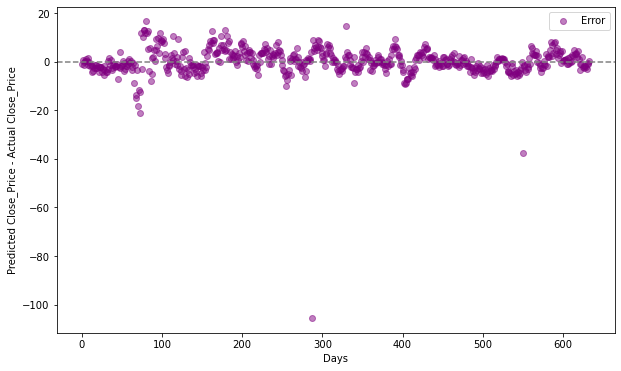

In [87]:
import matplotlib.pyplot as plt

errors = y_pred - adjusted_y
plt.figure(figsize=(10, 6))
plt.scatter(range(len(errors)), errors, color='purple', label='Error', alpha=0.5)
plt.axhline(y=0, color='gray', linestyle='--')
plt.title('')
plt.xlabel('Days')
plt.ylabel('Predicted Close_Price - Actual Close_Price')
plt.legend()
plt.show()

In [89]:
idx = list(errors).index(min(errors))
idx

287

In [ ]:
import shap

explainer = shap.KernelExplainer(regr.predict, X_train)

# 计算整个训练集的 SHAP 值
shap_values = explainer.shap_values(X_train)

shap.initjs()

# 选择一个具体的样本来可视化
sample_index = 0
shap.force_plot(explainer.expected_value, shap_values[sample_index], X_train.iloc[sample_index])

In [ ]:
# 打印特定样本的SHAP值
print(shap_values[0])

In [ ]:
shap.summary_plot(shap_values, X_train, 
                  plot_type="bar")

In [ ]:
shap.summary_plot(shap_values, X_train)

In [ ]:
abs_shap_values = np.abs(shap_values)

# 计算每个特征的 SHAP 值的平均
shap_means = np.mean(abs_shap_values, axis=0)

# 绘制每个特征对每个样本的 SHAP 值
plt.figure(figsize=(20, 10))
for i in range(abs_shap_values.shape[1]):  # 遍历每个特征
    plt.plot(abs_shap_values[:, i], label=X_train.columns[i])

# 绘制平均 SHAP 值的线
plt.plot(shap_means , color='black', linewidth=2, linestyle='--', label='Mean SHAP value')

plt.title('Abs SHAP Values for each Feature across all Samples')
plt.xlabel('Sample Index')
plt.ylabel('SHAP Value')
plt.legend()
plt.show()

In [ ]:
# 计算每个特征的 SHAP 值的平均
shap_means2 = np.mean(shap_values, axis=0)

# 绘制每个特征对每个样本的 SHAP 值
plt.figure(figsize=(20, 10))
for i in range(shap_values.shape[1]):  # 遍历每个特征
    plt.plot(shap_values[:, i], label=X_train.columns[i])

# 绘制平均 SHAP 值的线
plt.plot(shap_means2 , color='black', linewidth=2, linestyle='--', label='Mean SHAP value')

plt.title('SHAP Values for each Feature across all Samples')
plt.xlabel('Sample Index')
plt.ylabel('SHAP Value')
plt.legend()
plt.show()

In [ ]:
y_pred = []
total_cumulative_weights = None

for i in range(1200, X.shape[0]):
    print(f"current at {i}")
    size = 500
    start_index = max(i - size, 0)  # 确保索引不会出现负数
    X_train = X.iloc[start_index:i]
    y_train = y.iloc[start_index:i]
    X_test = X.iloc[i:i+1]

    # 使用 identity 激活函数训练模型
    regr = MLPRegressor(
        activation='identity', 
        random_state=1,
        hidden_layer_sizes=(100,),
        max_iter=1000
    ).fit(X_train, y_train)
    y_pred.append(regr.predict(X_test)[0])

    # 获取权重矩阵
    V_ij = regr.coefs_[0]  # 权重从输入层到隐藏层
    V_jk = regr.coefs_[1]  # 权重从隐藏层到输出层

    # 初始化当天的权重累计
    daily_cumulative_weights = np.zeros(V_ij.shape[0])

    # 累加当天的每个输入特征的权重
    for idx in range(V_ij.shape[0]):  # 遍历输入节点
        for j in range(V_ij.shape[1]):  # 遍历隐藏节点
            for k in range(V_jk.shape[1]):  # 遍历输出节点
                daily_cumulative_weights[idx] += V_ij[idx, j] * V_jk[j, k]

    # 将当天的权重累加到总累计中，取绝对值后累加
    if total_cumulative_weights is None:
        total_cumulative_weights = np.abs(daily_cumulative_weights)
    else:
        total_cumulative_weights += np.abs(daily_cumulative_weights)

In [ ]:
# 计算平均特征权重
average_weights = np.abs(total_cumulative_weights) / (X.shape[0] - 1200)
print("Average Feature Weights:", average_weights)

In [ ]:
feature_names = X_train.columns  # 获取特征名称
feature_weights = average_weights 

plt.figure(figsize=(10, 8))

plt.barh(feature_names, feature_weights, color='skyblue')
plt.xlabel('Feature Weight')  
plt.title('Feature Importance Visualization')  


for index, value in enumerate(feature_weights):
    plt.text(value, index, f'{value:.2f}')  
plt.show()  